# Challenges and Questions: final project phase
___

In [1]:
import sys
import os

milestone_2_path = os.path.abspath("../milestone 2")
sys.path.append(milestone_2_path)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import import_preprocess, baseline_models
from importlib import reload
reload(import_preprocess)
reload(baseline_models)

from import_preprocess import ImportPreprocess
from bert_models import BERTModel

d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initially, we'll identify which model performs best for our task (assumption: `HateBERT`). To do this, we'll start with the base scenario: a balanced or unbalanced dataset with the initial labels. 

Once we determine the best model, we'll retrain it using various scenarios, including both balanced and unbalanced datasets, along with 3 distinct types of label aggregation: `original` (provided by the dataset creators), `majority voting` (applied to the labels from 3 annotators) and `at least one sexist` (where a label is "sexist" if at least 1 annotator assigned it as such). These combinations of dataset type and aggregation method yield 6 distinct configurations for model training.

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset()

X_train, y_train, S_train, y_train_multi = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train, import_preprocess.y_train_multi
X_val, y_val, S_val, y_val_multi = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val, import_preprocess.y_val_multi
X_test, y_test, S_test, y_test_multi = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test, import_preprocess.y_test_multi
X_train_balanced, y_train_balanced = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced

# different aggregation methods
y_train_mv, y_train_balanced_mv, y_val_mv, y_test_mv = import_preprocess.apply_aggregation(aggregation_type='majority voting')
y_train_alos, y_train_balanced_alos, y_val_alos, y_test_alos = import_preprocess.apply_aggregation(aggregation_type='at least one sexist')

print("Number of training samples:", len(X_train)) 
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test)) 
print("Number of balanced samples:", len(X_train_balanced))

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 10000


# BERT-based models

We're exploring pre-trained models available on the Hugging Face model repository. We're using their pre-trained weights, coupled with tokenizers as our starting point. We're fine-tuning them to adapt them to our downstream task. We've implemented 2 approaches for fine-tuning (each requiring slightly different preprocessing steps).

#### 2 different types of fine-tuning

1. PyTorch fine-tuning

(`prepare_X` and `prepare_dataset` methods for pre-processing and `train` for training)
We've implemented the training loop using Pytorch. The process is straightforward: epoch-by-epoch and batch-by-batch, performing a forward pass through the network, computing the loss, backpropagating errors and updating parameters using gradient descent.

In [3]:
# model = BERTModel("HateBERT")
# model.train(X_train[:30], y_train[:30], X_val[:10], y_val[:10], epochs=10, patience=3, plot_training_curve=True)

2. Hugging Face Trainer API -> extremely slow :(

(`prepare_dataset_hf` method for pre-processing and `train_hugging_face_api` for training) HF provides Trainer API, which simplifies the training process by eliminating the need for manually implementing the training loop and various convinient features (such as early stopping, regularization, logging etc). Although this approach provides flexibility, in our case it resulted in way longer training times and higher overhead. Therefore, we decided to proceed with the first approach - PyTorch fine-tuning.

In [4]:
# model = BERTModel("HateBERT")
# model.train_hugging_face_api(X_train[:30], y_train[:30], X_val[:10], y_val[:10], epochs=10, patience=3)

### Training and evaluating various BERT-based models

In [5]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])

#### **1. RoBERTa**

https://arxiv.org/abs/1907.11692 (paper)

Key features of the original RoBERTa:
- improvement over BERT
- pre-trained in a self-supervised manner: raw texts only, with no humans labelling 
- dynamic masking: 
    - BERT uses static masking during pretraining (the same tokens are masked across all training epochs)
    - RoBERTa uses dynamic masking, where tokens are randomly masked in each epoch
- next sentence prediction loss (NSP):
    - BERT: includes NSP as part of its pretraining objective, where the model learns to predict whether one sentence logically follows another
    - RoBERTa: removes NSP because experiments showed that removing it leads to better results
- pre-training objective:
    - BERT: masked language modeling (MLM) objective along with the NSP task
    - RoBERTa: only the MLM objective 
- larger training data and batch size:
    - BERT: pretrained on 16GB of data (BooksCorpus and English Wikipedia); small batch size; 1 million training steps (pass of a batch)
    - RoBERTa: 10 times more data; larger batch size; 500,000 training steps

HF model we're using: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
- trained on ~124M tweets from January 2018 to December 2021 and finetuned for sentiment analysis with the TweetEval benchmark
- labels of the pre-trained model: 0 - negative; 1 - neutral; 2 - positive; by setting `ignore_mismatched_sizes=True` while loading the pre-trained model, the weights of the output layer won't be loaded, instead, they will be randomly initialized


Loading pretrained weights: RoBERTa...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

Pretrained weights loaded successfully.
Loading tokenizer...


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Tokenizer loaded sucessfully.
Total number of parameters in the model RoBERTa: 124647170
Training started.
Epoch 1/10, Cross-entropy Loss: 0.5670
Validation Loss: 0.8206, Validation Accuracy: 0.6000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 0.4518
Validation Loss: 0.8630, Validation Accuracy: 0.6000
No improvement. Patience: 1/3
Epoch 3/10, Cross-entropy Loss: 0.4304
Validation Loss: 0.7874, Validation Accuracy: 0.6000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 4/10, Cross-entropy Loss: 0.3679
Validation Loss: 0.7341, Validation Accuracy: 0.6000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 5/10, Cross-entropy Loss: 0.3542
Validation Loss: 0.7219, Validation Accuracy: 0.6000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 6/10, Cross-entropy Loss: 0.2713
Validation Loss: 0.7711, Validation Accuracy: 0.6000
No improvement. Patience: 1

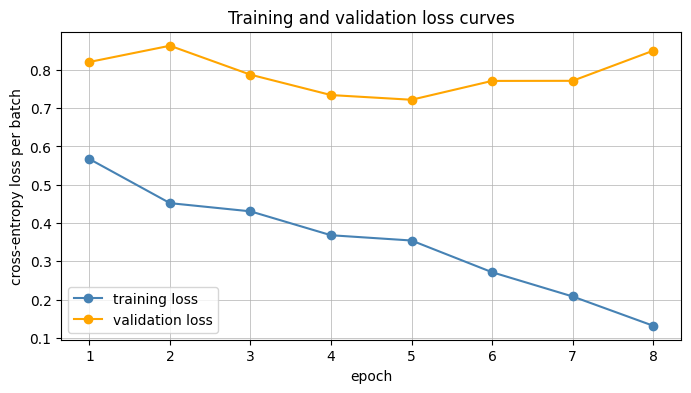

########################################

Metrics for training
accuracy: 1.0000
balanced accuracy: 1.0000
precision: 1.0000
recall: 1.0000

########################################

Metrics for validation
accuracy: 0.7000
balanced accuracy: 0.6250
precision: 1.0000
recall: 0.2500

########################################



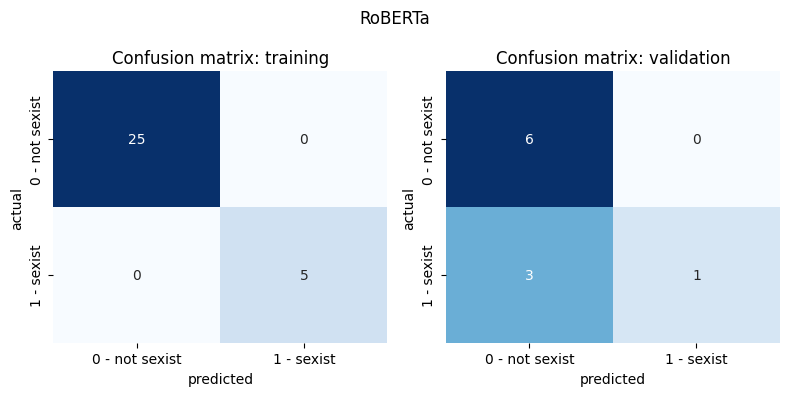

In [ ]:
roberta_model = BERTModel("RoBERTa")
roberta_model.count_parameters()
roberta_model.train(X_train, y_train, X_val, y_val, epochs=10, patience=3)

res = roberta_model.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name=roberta_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x

roberta_model.clear_gpu_memory()

#### **2. DeBERTa**

https://arxiv.org/abs/2006.03654 (paper)

Key features of the original DeBERTa:
- improvement over BERT and RoBERTa
- handling content and position information:
    - BERT: adds positional encoding to the embedding vectors to incorporate position information
    - DeBERTa: uses disentangled attention mechanism - each word represented with 2 separate vectors (1 encoding content and the other encoding position); attention weights are computed using disentangled matrices that separately handle content and positional information
- decoder part: 
    - BERT: uses the standard transformer encoder and positional encodings during the input processing, without a separate decoder mechanism
    - DeBERTa: uses enhanced mask decoder - the decoding layer incorporates absolute positions, allowing the model to better capture positional relationships and improve its ability to predict masked tokens.
- virtual adversarial training (VAT) method is used during fine-tuning to enhance generalization (making the model less sensitive to slight input changes and improving performance on downstream tasks)
- training data:
    - RoBERTa: ~160GB data
    - DeBERTa: trained on half of the training data used for RoBERTa-Large, but outperforms it across multiple NLP tasks

HF model we're using: https://huggingface.co/microsoft/deberta-v3-base

- base DeBERTa model fine-tuned with MNLI task (multi-genre natural language inference): determine the relationship between 2 sentences (3 categories: 1. entailment: 2nd sentence logically follows from the 1st, 2. contradiction: 2nd contradicts the 1st, 3. neutral)
- it might be better if we manage to find some model that was fine-tuned on the social media data or fine-tuned on some task more similar to our

Loading pretrained weights: DeBERTa...


You are using a model of type deberta-v2 to instantiate a model of type deberta. This is not supported for all configurations of models and can yield errors.
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'deberta.encoder.layer.0.attention.self.in_proj.weight', 'deberta.encoder.layer.0.attention.self.pos_proj.weight', 'deberta.encoder.layer.0.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.0.attention.self.pos_q_proj.weight', 'deberta.encoder.layer.0.attention.self.q_bias', 'deberta.encoder.layer.0.attention.self.v_bias', 'deberta.encoder.layer.1.attention.self.in_proj.weight', 'deberta.encoder.layer.1.attention.self.pos_proj.weight', 'deberta.encoder.layer.1.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.1.attention.self.pos_q_proj.weight', 'deberta.encoder.layer.1.attention.self.q_bias', 'deberta.encoder.layer.1.attention.s

Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model DeBERTa: 198971138
Training started.
Epoch 1/10, Cross-entropy Loss: 0.7041
Validation Loss: 0.6764, Validation Accuracy: 0.6000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 0.6247
Validation Loss: 0.6773, Validation Accuracy: 0.6000
No improvement. Patience: 1/3
Epoch 3/10, Cross-entropy Loss: 0.5241
Validation Loss: 0.8224, Validation Accuracy: 0.6000
No improvement. Patience: 2/3
Epoch 4/10, Cross-entropy Loss: 0.4375
Validation Loss: 0.8893, Validation Accuracy: 0.6000
No improvement. Patience: 3/3
Early stopping triggered.


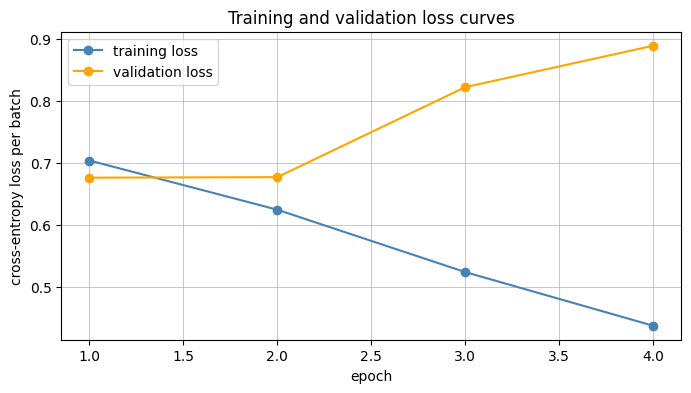

########################################

Metrics for training
accuracy: 0.8333
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.6000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



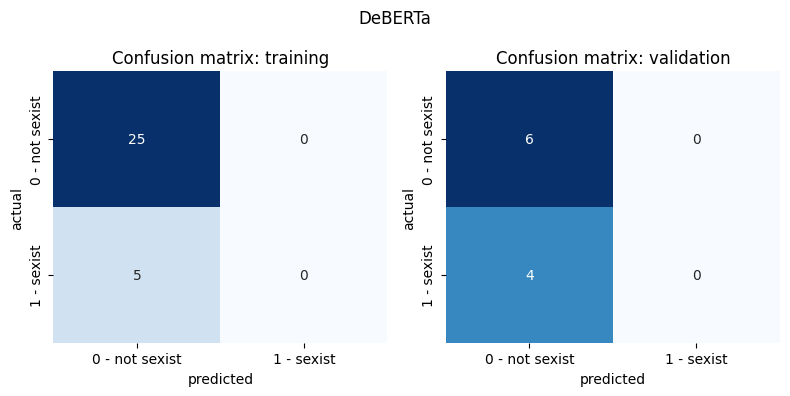

In [ ]:
deberta_model = BERTModel("DeBERTa")
deberta_model.count_parameters()
deberta_model.train(X_train, y_train, X_val, y_val, epochs=10, patience=3)

res = deberta_model.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name=deberta_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x

deberta_model.clear_gpu_memory()

#### **3. HateBERT**

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 0.8621
Validation Loss: 0.7040, Validation Accuracy: 0.5000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 0.6810
Validation Loss: 0.6817, Validation Accuracy: 0.6000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 3/10, Cross-entropy Loss: 0.5143
Validation Loss: 0.7041, Validation Accuracy: 0.6000
No improvement. Patience: 1/3
Epoch 4/10, Cross-entropy Loss: 0.4249
Validation Loss: 0.7372, Validation Accuracy: 0.6000
No improvement. Patience: 2/3
Epoch 5/10, Cross-entropy Loss: 0.3750
Validation Loss: 0.7706, Validation Accuracy: 0.6000
No improvement. Patience: 3/3
Early stopping triggered.


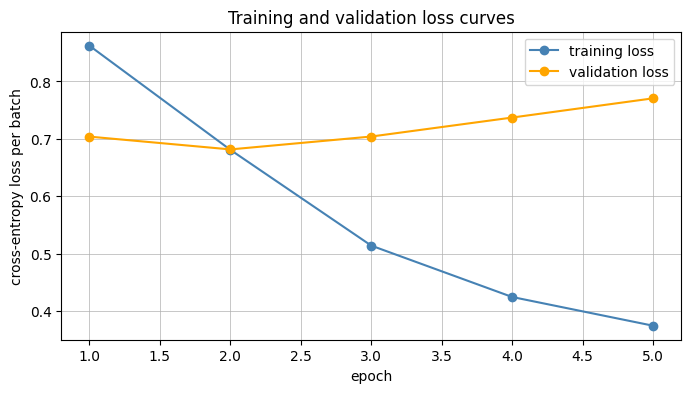

########################################

Metrics for training
accuracy: 0.8333
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.6000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



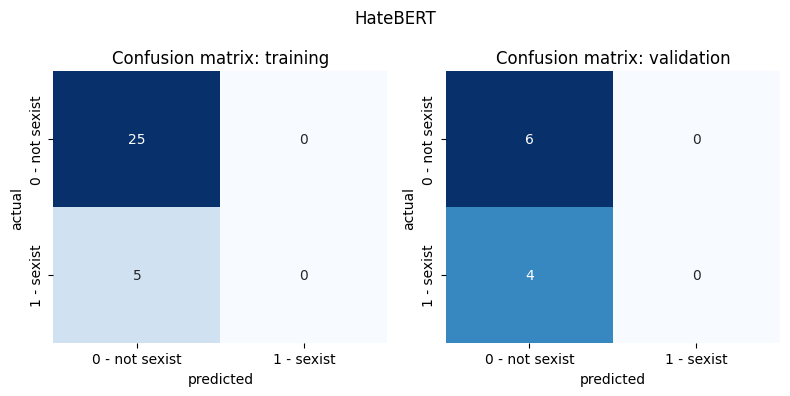

In [ ]:
hatebert_model = BERTModel("HateBERT")
hatebert_model.count_parameters()
hatebert_model.train(X_train, y_train, X_val, y_val, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name=hatebert_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x

hatebert_model.clear_gpu_memory()

#### **4. DistilBERT**

Loading pretrained weights: DistilBERT...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model DistilBERT: 66955010
Training started.
Epoch 1/10, Cross-entropy Loss: 0.7534
Validation Loss: 0.6643, Validation Accuracy: 0.6000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 0.6367
Validation Loss: 0.6387, Validation Accuracy: 0.6000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 3/10, Cross-entropy Loss: 0.5430
Validation Loss: 0.6282, Validation Accuracy: 0.6000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 4/10, Cross-entropy Loss: 0.4812
Validation Loss: 0.6286, Validation Accuracy: 0.6000
No improvement. Patience: 1/3
Epoch 5/10, Cross-entropy Loss: 0.4368
Validation Loss: 0.6410, Validation Accuracy: 0.6000
No improvement. Patience: 2/3
Epoch 6/10, Cross-entropy Loss: 0.4062
Validation Loss: 0.6601, Validation Accuracy: 0.6000
No im

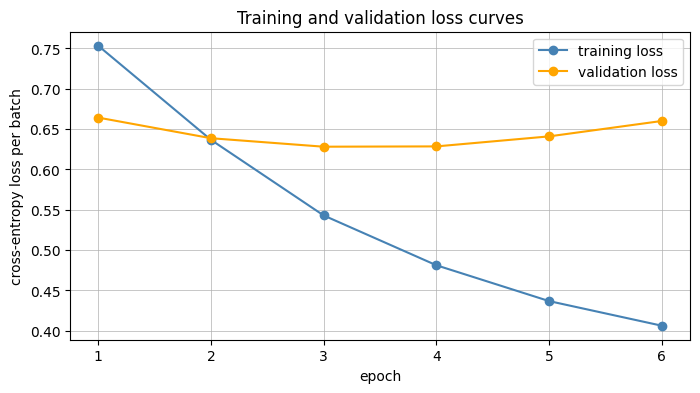

########################################

Metrics for training
accuracy: 0.8333
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.6000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



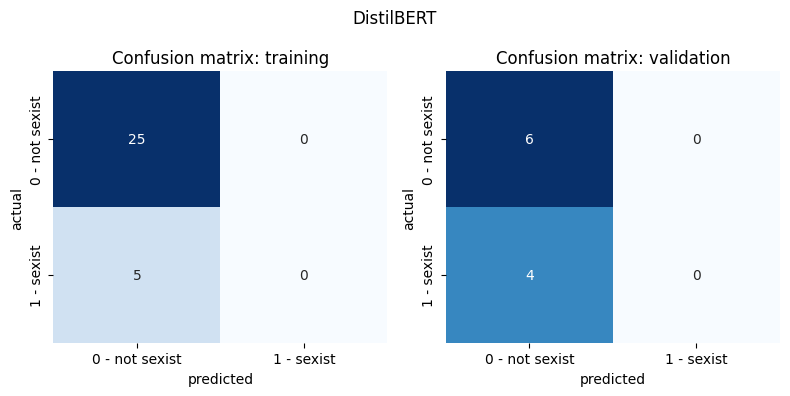

In [ ]:
distilbert_model = BERTModel("DistilBERT")
distilbert_model.count_parameters()
distilbert_model.train(X_train, y_train, X_val, y_val, epochs=10, patience=3)

res = distilbert_model.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name=distilbert_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x

distilbert_model.clear_gpu_memory()

### Results

In [10]:
results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,RoBERTa,training,1.000000,1.000,1.0,1.00
1,RoBERTa,validation,0.700000,0.625,1.0,0.25
2,DeBERTa,training,0.833333,0.500,0.0,0.00
3,DeBERTa,validation,0.600000,0.500,0.0,0.00
4,HateBERT,training,0.833333,0.500,0.0,0.00
5,HateBERT,validation,0.600000,0.500,0.0,0.00
6,DistilBERT,training,0.833333,0.500,0.0,0.00
7,DistilBERT,validation,0.600000,0.500,0.0,0.00


### Different aggregation methods

Let's train `HateBERT` under 6 different scenarios to explore potential performance improvements, using combinations of dataset types (balanced/unbalanced) and label aggregation methods (original labels, majority voting, at least one sexist).

In [11]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall', 'Aggregation Type'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall', 'Aggregation Type'])

**1. original labels**

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 0.7254
Validation Loss: 0.7153, Validation Accuracy: 0.6000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 0.5616
Validation Loss: 0.7243, Validation Accuracy: 0.6000
No improvement. Patience: 1/3
Epoch 3/10, Cross-entropy Loss: 0.4482
Validation Loss: 0.7435, Validation Accuracy: 0.6000
No improvement. Patience: 2/3
Epoch 4/10, Cross-entropy Loss: 0.3561
Validation Loss: 0.7602, Validation Accuracy: 0.6000
No improvement. Patience: 3/3
Early stopping triggered.


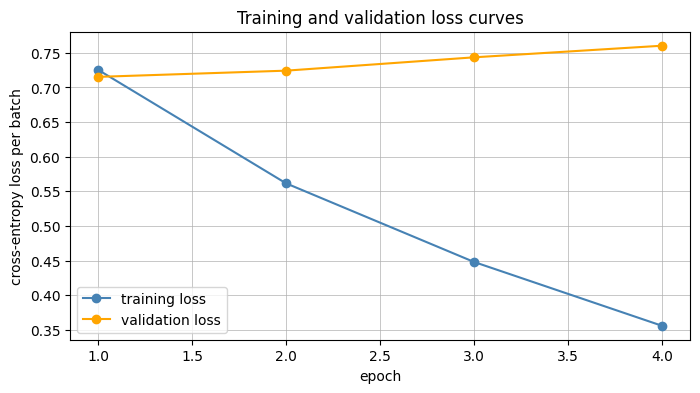

########################################

Metrics for training
accuracy: 0.8333
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.6000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



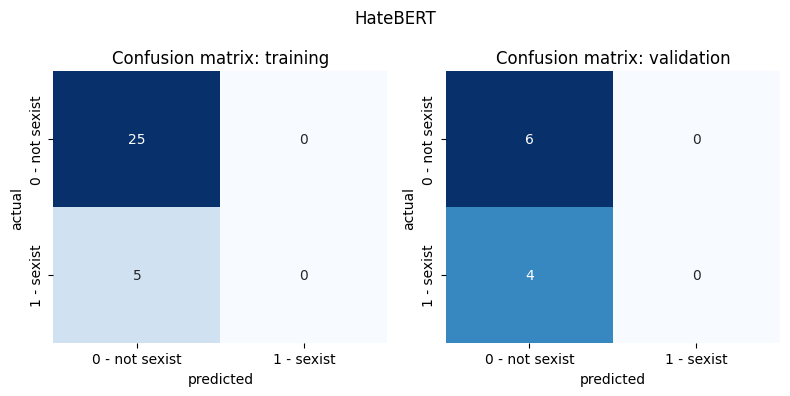

In [ ]:
hatebert_model = BERTModel("HateBERT", additional_info="unbalanced_original")
hatebert_model.count_parameters()
hatebert_model.train(X_train, y_train, X_val, y_val, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name=hatebert_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x + ['original']

hatebert_model.clear_gpu_memory()

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 0.7426
Validation Loss: 0.7612, Validation Accuracy: 0.4000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 0.6836
Validation Loss: 0.7375, Validation Accuracy: 0.4000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 3/10, Cross-entropy Loss: 0.5813
Validation Loss: 0.7445, Validation Accuracy: 0.5000
No improvement. Patience: 1/3
Epoch 4/10, Cross-entropy Loss: 0.5163
Validation Loss: 0.7619, Validation Accuracy: 0.5000
No improvement. Patience: 2/3
Epoch 5/10, Cross-entropy Loss: 0.4213
Validation Loss: 0.7811, Validation Accuracy: 0.3000
No improvement. Patience: 3/3
Early stopping triggered.


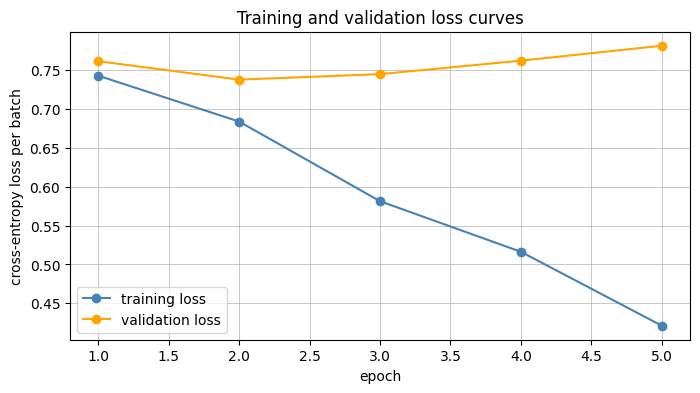

########################################

Metrics for training
accuracy: 1.0000
balanced accuracy: 1.0000
precision: 1.0000
recall: 1.0000

########################################

Metrics for validation
accuracy: 0.3000
balanced accuracy: 0.2500
precision: 0.0000
recall: 0.0000

########################################



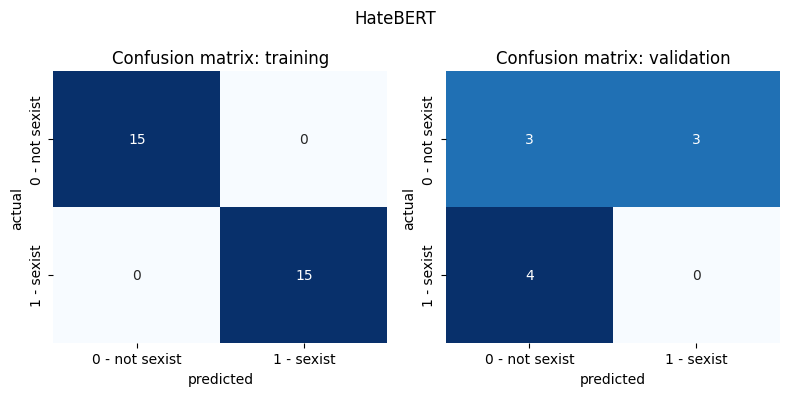

In [ ]:
hatebert_model = BERTModel("HateBERT", additional_info="balanced_original")
hatebert_model.count_parameters()
hatebert_model.train(X_train_balanced, y_train_balanced, X_val, y_val, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train_balanced, "validation": X_val}, [y_train_balanced, y_val], model_name=hatebert_model.model_name)
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x + ['original']

hatebert_model.clear_gpu_memory()

**2. majority voting**

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 0.6587
Validation Loss: 0.6136, Validation Accuracy: 0.7000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 0.5474
Validation Loss: 0.5967, Validation Accuracy: 0.7000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 3/10, Cross-entropy Loss: 0.4997
Validation Loss: 0.5944, Validation Accuracy: 0.7000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 4/10, Cross-entropy Loss: 0.4625
Validation Loss: 0.5996, Validation Accuracy: 0.7000
No improvement. Patience: 1/3
Epoch 5/10, Cross-entropy Loss: 0.4086
Validation Loss: 0.6036, Validation Accuracy: 0.7000
No improvement. Patience: 2/3
Epoch 6/10, Cross-entropy Loss: 0.3544
Validation Loss: 0.6007, Validation Accuracy: 0.7000
No imp

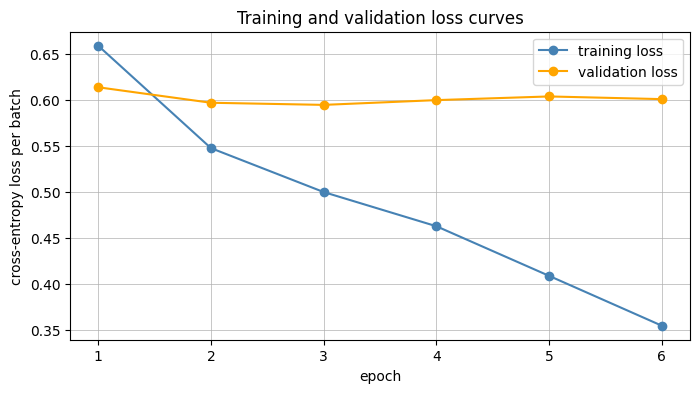

########################################

Metrics for training
accuracy: 0.8000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



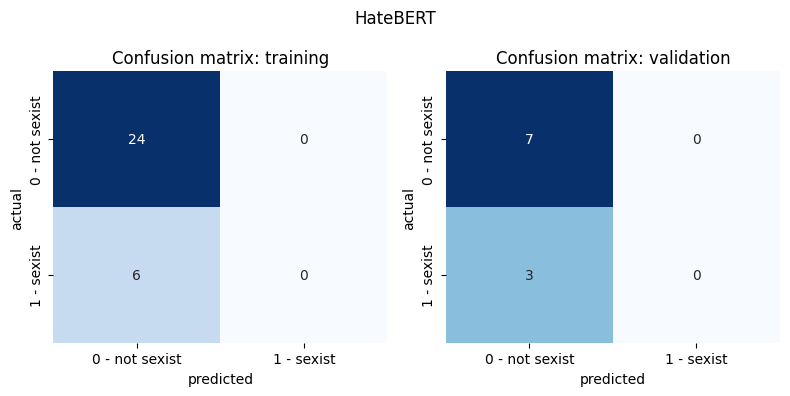

In [ ]:
hatebert_model = BERTModel("HateBERT", additional_info="unbalanced_majority_voting")
hatebert_model.count_parameters()
hatebert_model.train(X_train, y_train_mv, X_val, y_val_mv, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train, "validation": X_val}, [y_train_mv, y_val_mv], model_name=hatebert_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x + ['majority voting']

hatebert_model.clear_gpu_memory()

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 0.7264
Validation Loss: 0.7143, Validation Accuracy: 0.3000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 0.6526
Validation Loss: 0.7638, Validation Accuracy: 0.3000
No improvement. Patience: 1/3
Epoch 3/10, Cross-entropy Loss: 0.5507
Validation Loss: 0.8060, Validation Accuracy: 0.2000
No improvement. Patience: 2/3
Epoch 4/10, Cross-entropy Loss: 0.4749
Validation Loss: 0.8305, Validation Accuracy: 0.3000
No improvement. Patience: 3/3
Early stopping triggered.


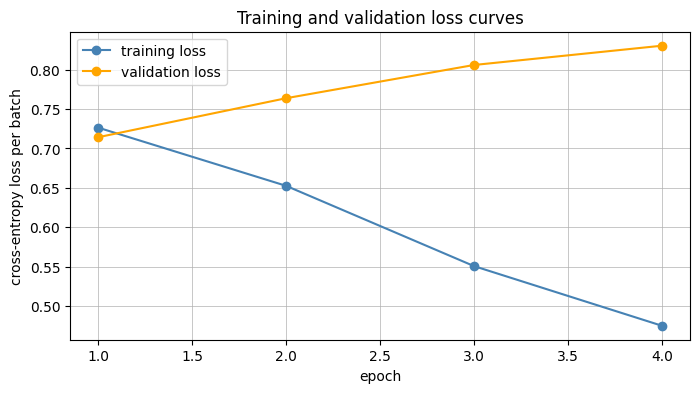

########################################

Metrics for training
accuracy: 1.0000
balanced accuracy: 1.0000
precision: 1.0000
recall: 1.0000

########################################

Metrics for validation
accuracy: 0.3000
balanced accuracy: 0.4048
precision: 0.2500
recall: 0.6667

########################################



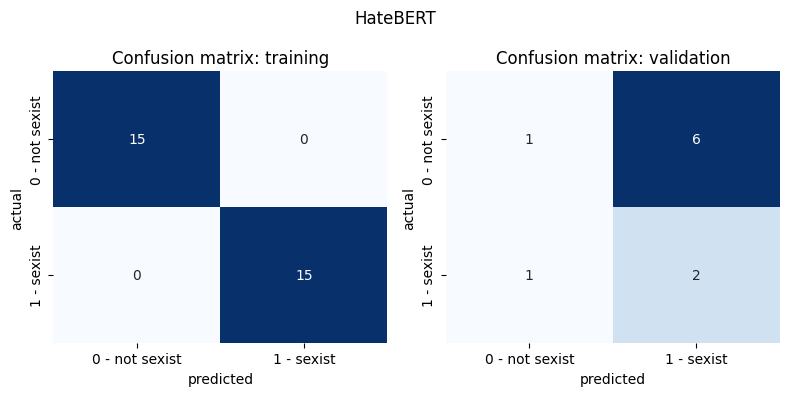

In [ ]:
hatebert_model = BERTModel("HateBERT", additional_info="balanced_majority_voting")
hatebert_model.count_parameters()
hatebert_model.train(X_train_balanced, y_train_balanced_mv, X_val, y_val_mv, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train_balanced, "validation": X_val}, [y_train_balanced_mv, y_val_mv], model_name=hatebert_model.model_name)
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x + ['majority voting']

hatebert_model.clear_gpu_memory()

**3. at least one sexist**

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 0.7532
Validation Loss: 0.7161, Validation Accuracy: 0.6000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 0.6511
Validation Loss: 0.7060, Validation Accuracy: 0.6000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 3/10, Cross-entropy Loss: 0.5442
Validation Loss: 0.7101, Validation Accuracy: 0.6000
No improvement. Patience: 1/3
Epoch 4/10, Cross-entropy Loss: 0.4817
Validation Loss: 0.7170, Validation Accuracy: 0.6000
No improvement. Patience: 2/3
Epoch 5/10, Cross-entropy Loss: 0.4727
Validation Loss: 0.7181, Validation Accuracy: 0.6000
No improvement. Patience: 3/3
Early stopping triggered.


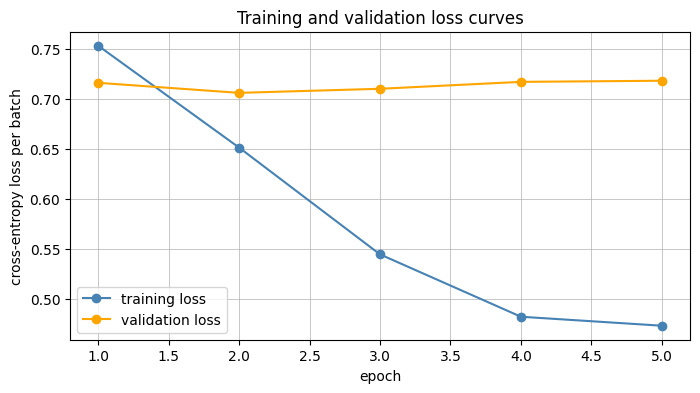

########################################

Metrics for training
accuracy: 0.7667
balanced accuracy: 0.5625
precision: 1.0000
recall: 0.1250

########################################

Metrics for validation
accuracy: 0.6000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



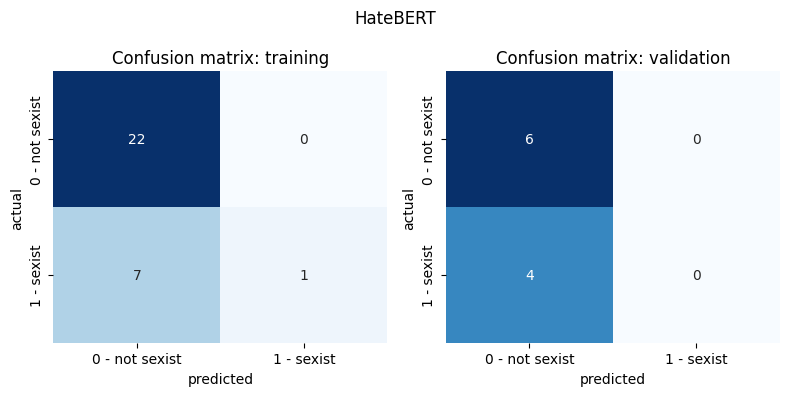

In [ ]:
hatebert_model = BERTModel("HateBERT", additional_info="unbalanced_at_least_one_sexist")
hatebert_model.count_parameters()
hatebert_model.train(X_train, y_train_alos, X_val, y_val_alos, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train, "validation": X_val}, [y_train_alos, y_val_alos], model_name=hatebert_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x + ['at least one sexist']

hatebert_model.clear_gpu_memory()

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 0.6168
Validation Loss: 0.8971, Validation Accuracy: 0.4000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 0.5536
Validation Loss: 0.8734, Validation Accuracy: 0.4000
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 3/10, Cross-entropy Loss: 0.4600
Validation Loss: 0.8758, Validation Accuracy: 0.4000
No improvement. Patience: 1/3
Epoch 4/10, Cross-entropy Loss: 0.3961
Validation Loss: 0.8853, Validation Accuracy: 0.4000
No improvement. Patience: 2/3
Epoch 5/10, Cross-entropy Loss: 0.2982
Validation Loss: 0.9066, Validation Accuracy: 0.4000
No improvement. Patience: 3/3
Early stopping triggered.


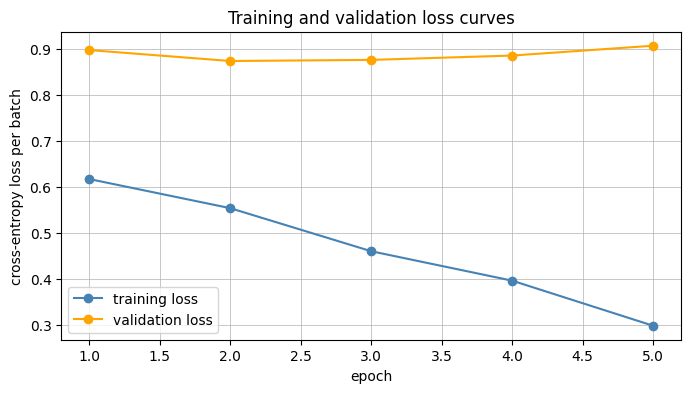

########################################

Metrics for training
accuracy: 1.0000
balanced accuracy: 1.0000
precision: 1.0000
recall: 1.0000

########################################

Metrics for validation
accuracy: 0.4000
balanced accuracy: 0.5000
precision: 0.4000
recall: 1.0000

########################################



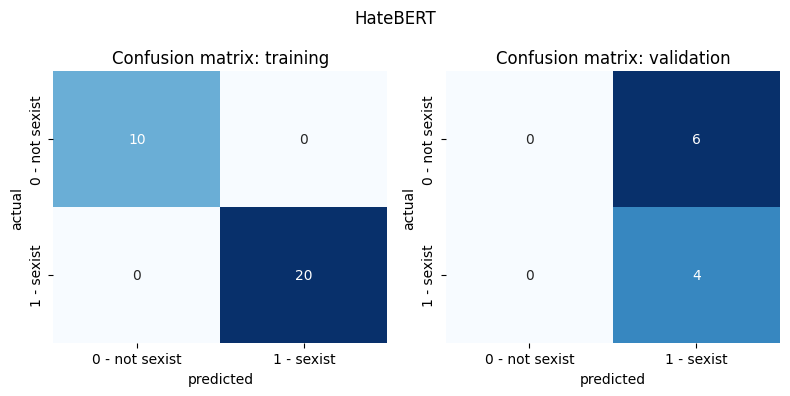

In [ ]:
hatebert_model = BERTModel("HateBERT", additional_info="balanced_at_least_one_sexist")
hatebert_model.count_parameters()
hatebert_model.train(X_train_balanced, y_train_balanced_alos, X_val, y_val_alos, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train_balanced, "validation": X_val}, [y_train_balanced_alos, y_val_alos], model_name=hatebert_model.model_name)
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x + ['at least one sexist']

hatebert_model.clear_gpu_memory()

#### Results

In [18]:
results.set_index(['Model', 'Aggregation Type']).sort_index()

Dataset  Accuracy  Balanced_Accuracy  \
Model    Aggregation Type                                               
HateBERT at least one sexist    training  0.766667             0.5625   
         at least one sexist  validation  0.600000             0.5000   
         majority voting        training  0.800000             0.5000   
         majority voting      validation  0.700000             0.5000   
         original               training  0.833333             0.5000   
         original             validation  0.600000             0.5000   

                              Precision  Recall  
Model    Aggregation Type                        
HateBERT at least one sexist        1.0   0.125  
         at least one sexist        0.0   0.000  
         majority voting            0.0   0.000  
         majority voting            0.0   0.000  
         original                   0.0   0.000  
         original                   0.0   0.000

In [19]:
balanced_results.set_index(['Model', 'Aggregation Type']).sort_index()

Dataset  Accuracy  Balanced_Accuracy  \
Model    Aggregation Type                                               
HateBERT at least one sexist    training       1.0           1.000000   
         at least one sexist  validation       0.4           0.500000   
         majority voting        training       1.0           1.000000   
         majority voting      validation       0.3           0.404762   
         original               training       1.0           1.000000   
         original             validation       0.3           0.250000   

                              Precision    Recall  
Model    Aggregation Type                          
HateBERT at least one sexist       1.00  1.000000  
         at least one sexist       0.40  1.000000  
         majority voting           1.00  1.000000  
         majority voting           0.25  0.666667  
         original                  1.00  1.000000  
         original                  0.00  0.000000

# Qualitative analysis of HateBERT model

In [ ]:
bert_model = BERTModel("HateBERT", load_path="best_model", additional_info="balanced_original") # load from checkpoint

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\Natural Language Processing\Project new\NLP_24W_VSHJ\challenges\bert_models.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user vi

Pretrained weights loaded successfully.
Loading model weights from best_model...
Model loaded from best_model.
Loading tokenizer...
Tokenizer loaded sucessfully.


# Autoregressive models: LLAMA